In [133]:

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import sys


In [134]:
# input image dimensions
img_rows, img_cols = 28, 28

In [135]:
batch_size = 128
num_classes = 10
epochs = 50


In [136]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [137]:
x_train.shape

(60000, 28, 28)

In [138]:
iterations = np.ceil((x_train.shape[0]*epochs)/batch_size)

iterations_per_epoch = np.ceil((x_train.shape[0])/batch_size)

num_batch = int(x_train.shape[0]/batch_size)

In [139]:
x_train = np.reshape(np.array(x_train), (60000, 784))
x_test = np.reshape(np.array(x_test), (10000, 784))
x_train = x_train / 255
x_test = x_test / 255

In [140]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [141]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [142]:
# Function to create individual model
def k_model(output_dim,input_dim):
    model = Sequential() 
    model.add(Dense(output_dim, input_dim=input_dim)) 
    model.add(Activation('softmax'))
    return model

# def k_model(output_dim,input_dim):
#     model = Sequential() 
#     model.add(Dense(1000, input_dim=input_dim))
#     model.add(Activation('relu'))
#     model.add(Dense(output_dim))
#     model.add(Activation('softmax'))
#     return model

In [143]:
# Function to show the loss plot of training and validation set
def loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### Baseline model 
Got one layer that maps input to 10 classes

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 1.2768 - acc: 0.6982 - val_loss: 0.8028 - val_acc: 0.8358
Epoch 2/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.7123 - acc: 0.8398 - val_loss: 0.6044 - val_acc: 0.8652
Epoch 3/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.5856 - acc: 0.8593 - val_loss: 0.5245 - val_acc: 0.8758
Epoch 4/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.5248 - acc: 0.8683 - val_loss: 0.4797 - val_acc: 0.8822
Epoch 5/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.4876 - acc: 0.8752 - val_loss: 0.4502 - val_acc: 0.8859
Epoch 6/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.4619 - acc: 0.8800 - val_loss: 0.4293 - val_acc: 0.8905
Epoch 7/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.4430 - acc: 0.8833 - val_loss: 0.4132 - val_acc

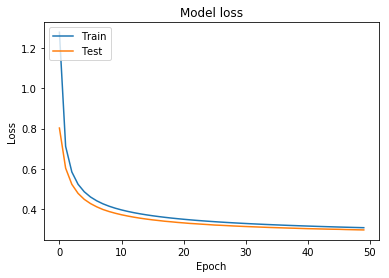

In [144]:
base_model=k_model(10,784)
lr = [0.01,0.05, 0.1, 0.001 , 0.005]
lr = [0.001]
batch_size = [16,32,64,128]
for i in lr :
    base_model=k_model(10,784)
    base_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, nesterov=False),
                  metrics=['accuracy'])
    
 
    base_model = base_model.fit(x_train, y_train,
              batch_size=128,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
        
    loss(base_model)

## The baseline model gives an accuracy of 91.36% at the end of 50 epochs

In [15]:
base_model.evaluate(x_train, y_train)

60000/60000 [==============================] - 2s 30us/step


[2.3025851249694824, 0.09871666666666666]

### Local SGD

Below is the list of variables:
1. Number of nodes
2. Learning rate
3. Time step
4. Data - Distributed/Not distributed

In [146]:
def list_model(n):
    l = []
    for i in range(n):
         l.append(k_model(10,784))
    
    return l

In [147]:
def define_model(n,alpha):
    models = list_model(n)
    

    num_batch = len(y_train) // batch_size

    #        c.append(0)
    #        loss.append([])

    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False, clipvalue=0.5),
                    metrics=['accuracy'])
    
    return models

In [207]:
def local_sgd(model,n,t,alpha,epoch,batch_size,train_data,test_data): 
    '''
    This function performs local sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(model)
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
        
    # At present the loop is designed to handle only one layer in the network. Will be modified to accomodate any number of layers
    for i in range(epoch):
        weights = []

        # This loop runs as long as the subsequent updates in c causes it to increase. c becomes 0 whenever the epoch completes
        while (True):
            c_prev = c
            
            # After every t iteration averaging the gradients
            for j in range(t):
                for k in range(len(models)):
                    batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                    batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                    models[k].train_on_batch(batch_x, batch_y)
                    
                c += 1
                c= c % num_batch
                
            if c_prev > c :
                break

            # Obtaining the weights from each model
            for l in range(len(models)):
                weights.append(models[l].layers[0].get_weights())

            new_weight = weights[0]
            
            # Averaging the weights and assigning it to each model on the nodes
            for l in range(1,n):
                if l !=n-1:
                    new_layer=[j+k for j,k in zip(new_weight,weights[l])]
                else:
                    new_layer=[(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
            for l in range(len(models)):
                models[l].set_weights(new_weight)


        # Evalutaing the losses (train and test and appending it to the list)
        loss_tr = models[0].evaluate(train_data[0],train_data[1])
        loss_te = models[0].evaluate(test_data[0],test_data[1])
        print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
        train_loss.append(loss_tr[0])
        test_loss.append(loss_te[0])
    
    return (train_loss,test_loss)

### The below 4 cells runs the local SGD model for 2,4,8,16 number of nodes and tunes the learning rate by taking 4 different values for each

In [188]:

model_parallel = k_model(10,784)
local_2_10_001 = local_sgd(model_parallel,2,10,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_01 = local_sgd(model_parallel,2,10,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_05 = local_sgd(model_parallel,2,10,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_1 = local_sgd(model_parallel,2,10,0.1,50,128,(x_train,y_train),(x_test,y_test))



10000/10000 [==============================] - 1s 64us/step
Epoch 0 of 50 : train loss - 2.2717501598358156 : train accuracy - 0.10543333333333334 test loss - 2.2689657638549803 test accuracy - 0.105
10000/10000 [==============================] - 1s 65us/step
Epoch 1 of 50 : train loss - 2.227668657430013 : train accuracy - 0.13385 test loss - 2.2241558963775634 test accuracy - 0.1329
10000/10000 [==============================] - 1s 74us/step
Epoch 2 of 50 : train loss - 2.186286185455322 : train accuracy - 0.16563333333333333 test loss - 2.18212087020874 test accuracy - 0.1655
10000/10000 [==============================] - 1s 83us/step
Epoch 3 of 50 : train loss - 2.146984664408366 : train accuracy - 0.19965 test loss - 2.1421700565338133 test accuracy - 0.1957
10000/10000 [==============================] - 1s 83us/step
Epoch 4 of 50 : train loss - 2.1082370157241823 : train accuracy - 0.2339 test loss - 2.1028765270233154 test accuracy - 0.2303
10000/10000 [=========================

In [189]:
model_parallel = k_model(10,784)
local_4_10_001 = local_sgd(model_parallel,4,10,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_01 = local_sgd(model_parallel,4,10,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_05 = local_sgd(model_parallel,4,10,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_1 = local_sgd(model_parallel,4,10,0.1,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 1s 64us/step
Epoch 0 of 50 : train loss - 2.255717309697469 : train accuracy - 0.16615 test loss - 2.2491130535125734 test accuracy - 0.1695
10000/10000 [==============================] - 1s 65us/step
Epoch 1 of 50 : train loss - 2.1796183364868162 : train accuracy - 0.21366666666666667 test loss - 2.1711595134735107 test accuracy - 0.2172
10000/10000 [==============================] - 1s 64us/step
Epoch 2 of 50 : train loss - 2.1084586484273276 : train accuracy - 0.2695166666666667 test loss - 2.098463039779663 test accuracy - 0.2744
10000/10000 [==============================] - 1s 68us/step
Epoch 3 of 50 : train loss - 2.0410881558736165 : train accuracy - 0.32863333333333333 test loss - 2.0295465267181396 test accuracy - 0.3364
10000/10000 [==============================] - 1s 74us/step
Epoch 4 of 50 : train loss - 1.9771721625010172 : train accuracy - 0.38726666666666665 test loss - 1.9643627307891847 test accuracy - 0.3987
10000/1000

In [190]:
model_parallel = k_model(10,784)
local_8_10_001 = local_sgd(model_parallel,8,10,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_01 = local_sgd(model_parallel,8,10,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_05 = local_sgd(model_parallel,8,10,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_1 = local_sgd(model_parallel,8,10,0.1,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 1s 72us/step
Epoch 0 of 50 : train loss - 2.253052206548055 : train accuracy - 0.17756666666666668 test loss - 2.24841068611145 test accuracy - 0.1834
10000/10000 [==============================] - 1s 70us/step
Epoch 1 of 50 : train loss - 2.093098405901591 : train accuracy - 0.3098166666666667 test loss - 2.085036703109741 test accuracy - 0.3159
10000/10000 [==============================] - 1s 70us/step
Epoch 2 of 50 : train loss - 1.9562471089045206 : train accuracy - 0.42196666666666666 test loss - 1.9456017740249634 test accuracy - 0.4339
10000/10000 [==============================] - 1s 66us/step
Epoch 3 of 50 : train loss - 1.83640032081604 : train accuracy - 0.514 test loss - 1.8236101913452147 test accuracy - 0.5297
10000/10000 [==============================] - 1s 77us/step
Epoch 4 of 50 : train loss - 1.7305945395787556 : train accuracy - 0.5842333333333334 test loss - 1.7161073085784913 test accuracy - 0.5925
10000/10000 [=====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 1s 66us/step
Epoch 32 of 50 : train loss - 0.39353055920600893 : train accuracy - 0.8931333333333333 test loss - 0.3724585854053497 test accuracy - 0.9009
10000/10000 [==============================] - 1s 70us/step
Epoch 33 of 50 : train loss - 0.3911369199633598 : train accuracy - 0.8935666666666666 test loss - 0.370217593061924 test accuracy - 0.9012
10000/10000 [==============================] - 1s 67us/step
Epoch 34 of 50 : train loss - 0.389124298675855 : train accuracy - 0.8937166666666667 test loss - 0.3681054614663124 test accuracy - 0.9018
10000/10000 [==============================] - 1s 66us/step
Epoch 35 of 50 : train loss - 0.38698911888599397 : train accuracy - 0.89445 test loss - 0.3660845528483391 test accuracy - 0.9019
10000/10000 [==============================] - 1s 71us/step
Epoch 36 of 50 : train loss - 0.3849043584426244 : train accuracy - 0.8950333333333333 test loss - 0.3642337681412697 test accuracy - 0.9024
10000/

In [ ]:
model_parallel = k_model(10,784)
local_16_10_001 = local_sgd(model_parallel,16,10,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_01 = local_sgd(model_parallel,16,10,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_05 = local_sgd(model_parallel,16,10,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_1 = local_sgd(model_parallel,16,10,0.1,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 1s 74us/step
Epoch 0 of 50 : train loss - 2.0292985248565674 : train accuracy - 0.3625833333333333 test loss - 2.02524135055542 test accuracy - 0.3651
10000/10000 [==============================] - 1s 75us/step
Epoch 1 of 50 : train loss - 1.7841574268341065 : train accuracy - 0.5610166666666667 test loss - 1.7749642070770264 test accuracy - 0.5716
10000/10000 [==============================] - 1s 74us/step
Epoch 2 of 50 : train loss - 1.594353267923991 : train accuracy - 0.6519833333333334 test loss - 1.58131263961792 test accuracy - 0.6591
10000/10000 [==============================] - 1s 74us/step
Epoch 3 of 50 : train loss - 1.4454287611643473 : train accuracy - 0.6986666666666667 test loss - 1.4294782882690429 test accuracy - 0.7079
10000/10000 [==============================] - 1s 72us/step
Epoch 4 of 50 : train loss - 1.3269052308718363 : train accuracy - 0.7320166666666666 test loss - 1.3087664958953857 test accuracy - 0.7429
10000

In [193]:
# Function to show the loss plot of training and validation set
def combined_loss(losses,description):
    for i in losses :
        plt.plot(i[0])
        plt.title('Train loss')
        
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(description, loc='upper left')
    plt.show()
    
    for i in losses :
        plt.plot(i[1])
        plt.title('Test loss')
        
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(description, loc='upper left')
    plt.show()

### Train test loss for node = 2

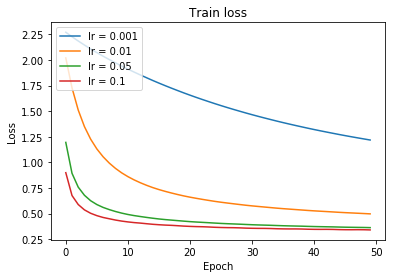

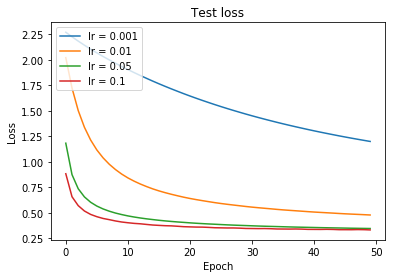

In [194]:
losses_2 = [local_2_10_001,local_2_10_01,local_2_10_05,local_2_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for node = 4

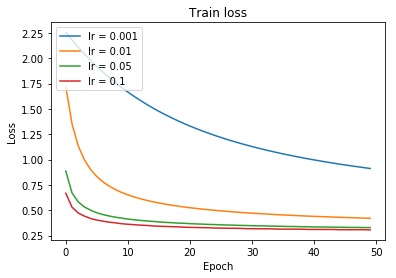

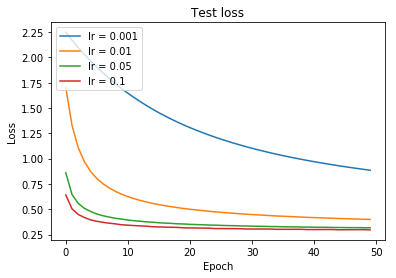

In [195]:
losses_2 = [local_4_10_001,local_4_10_01,local_4_10_05,local_4_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train Test loss for nodes = 8

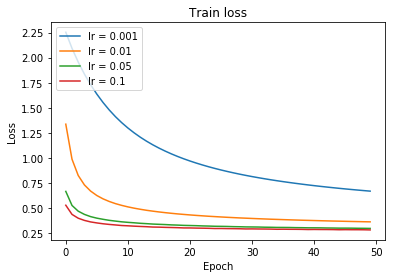

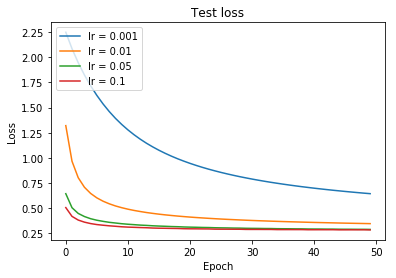

In [196]:
losses_2 = [local_8_10_001,local_8_10_01,local_8_10_05,local_8_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for nodes = 16

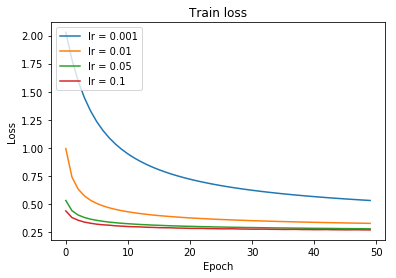

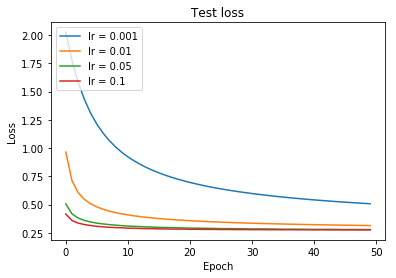

In [197]:
losses_2 = [local_16_10_001,local_16_10_01,local_16_10_05,local_16_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for lr = 0.01 and nodes = 2,4,8,16

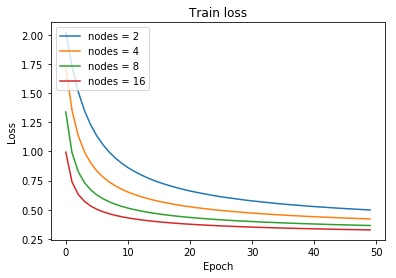

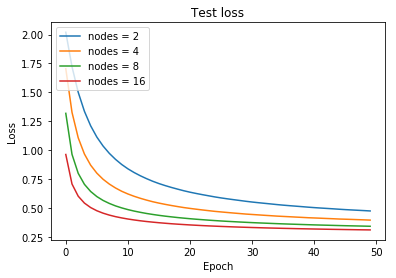

In [198]:
losses_2 = [local_2_10_01,local_4_10_01,local_8_10_01,local_16_10_01]
desc = ['nodes = 2','nodes = 4','nodes = 8','nodes = 16']
combined_loss(losses_2,desc)

In [200]:
model_parallel = k_model(10,784)
local_8_16_01 = local_sgd(model_parallel,8,16,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_8_01 = local_sgd(model_parallel,8,8,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_4_01 = local_sgd(model_parallel,8,4,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_2_01 = local_sgd(model_parallel,8,2,0.01,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 1s 84us/step
Epoch 0 of 50 : train loss - 1.0959417337735493 : train accuracy - 0.7778666666666667 test loss - 1.068135033226013 test accuracy - 0.7895
10000/10000 [==============================] - 1s 83us/step
Epoch 1 of 50 : train loss - 0.807214102490743 : train accuracy - 0.8274666666666667 test loss - 0.7781597945213318 test accuracy - 0.8359
10000/10000 [==============================] - 1s 79us/step
Epoch 2 of 50 : train loss - 0.6848024074395498 : train accuracy - 0.8444833333333334 test loss - 0.6558253241539002 test accuracy - 0.8547
10000/10000 [==============================] - 1s 84us/step
Epoch 3 of 50 : train loss - 0.6151775456984838 : train accuracy - 0.8535833333333334 test loss - 0.5869346555709839 test accuracy - 0.8644
10000/10000 [==============================] - 1s 83us/step
Epoch 4 of 50 : train loss - 0.5695811890125274 : train accuracy - 0.8612666666666666 test loss - 0.5424676107883454 test accuracy - 0.8715
10

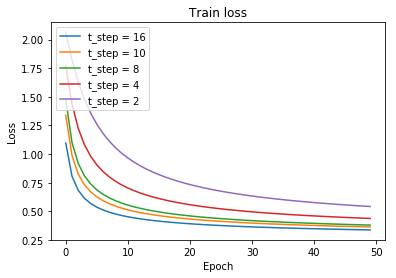

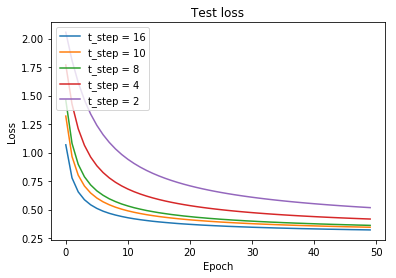

In [202]:
losses_time = [local_8_16_01,local_8_10_01,local_8_8_01,local_8_4_01,local_8_2_01]
desc = ['t_step = 16','t_step = 10','t_step = 8','t_step = 4','t_step = 2']
combined_loss(losses_time,desc)

In [203]:
model_parallel = k_model(10,784)
local_8_100_01 = local_sgd(model_parallel,8,100,0.01,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 1s 89us/step
Epoch 0 of 50 : train loss - 0.5275043116172154 : train accuracy - 0.8679833333333333 test loss - 0.5055007977724075 test accuracy - 0.8756
10000/10000 [==============================] - 1s 86us/step
Epoch 1 of 50 : train loss - 0.4369343243757884 : train accuracy - 0.8848166666666667 test loss - 0.41630705831050874 test accuracy - 0.8928
10000/10000 [==============================] - 1s 87us/step
Epoch 2 of 50 : train loss - 0.39888404026826224 : train accuracy - 0.8929333333333334 test loss - 0.37976445053815844 test accuracy - 0.8996
10000/10000 [==============================] - 1s 89us/step
Epoch 3 of 50 : train loss - 0.3769352180580298 : train accuracy - 0.8974166666666666 test loss - 0.35906272835731506 test accuracy - 0.9027
10000/10000 [==============================] - 1s 90us/step
Epoch 4 of 50 : train loss - 0.3621252117375533 : train accuracy - 0.9006666666666666 test loss - 0.34554625840187075 test accuracy - 0.

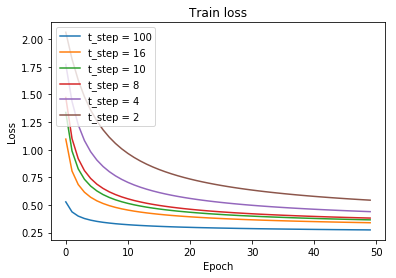

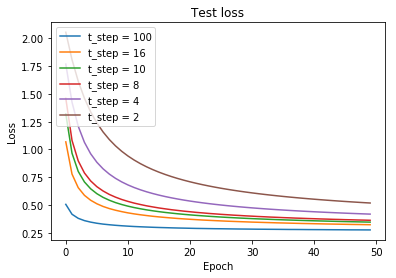

In [204]:
losses_time = [local_8_100_01,local_8_16_01,local_8_10_01,local_8_8_01,local_8_4_01,local_8_2_01]
desc = ['t_step = 100','t_step = 16','t_step = 10','t_step = 8','t_step = 4','t_step = 2']
combined_loss(losses_time,desc)

In [209]:
# One Shot Averaging : Minor tweaking in the previous function 

def local_sgd_oneshot_avg(model,n,t,alpha,epoch,batch_size,train_data,test_data): 
    '''
    This function performs local sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(model)
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
        
    # At present the loop is designed to handle only one layer in the network. Will be modified to accomodate any number of layers
    for i in range(epoch):
        weights = []

        # This loop runs as long as the subsequent updates in c causes it to increase. c becomes 0 whenever the epoch completes
        while (True):
            c_prev = c
            
            # After every t iteration averaging the gradients
            for j in range(t):
                for k in range(len(models)):
                    batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                    batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                    models[k].train_on_batch(batch_x, batch_y)
                    
                c += 1
                c= c % num_batch
                
            if c_prev > c :
                break

            # Obtaining the weights from each model
            '''for l in range(len(models)):
                weights.append(models[l].layers[0].get_weights())

            new_weight = weights[0]
            
            # Averaging the weights and assigning it to each model on the nodes
            for l in range(1,n):
                if l !=n-1:
                    new_layer=[j+k for j,k in zip(new_weight,weights[l])]
                else:
                    new_layer=[(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
            for l in range(len(models)):
                models[l].set_weights(new_weight)'''


        # Evalutaing the losses (train and test and appending it to the list)
        if (i != epoch - 1) :
            loss_tr = models[0].evaluate(train_data[0],train_data[1])
            loss_te = models[0].evaluate(test_data[0],test_data[1])
            print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
            train_loss.append(loss_tr[0])
            test_loss.append(loss_te[0])
            
    for l in range(len(models)):
        weights.append(models[l].layers[0].get_weights())
        new_weight = weights[0]
            
    # Averaging the weights and assigning it to each model on the nodes
    for l in range(1,n):
        if l !=n-1:
            new_layer=[j+k for j,k in zip(new_weight,weights[l])]
        else:
            new_layer=[(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
    for l in range(len(models)):
            models[l].set_weights(new_weight)
            

    loss_tr = models[0].evaluate(train_data[0],train_data[1])
    loss_te = models[0].evaluate(test_data[0],test_data[1])
    print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
    train_loss.append(loss_tr[0])
    test_loss.append(loss_te[0])

    
    return (train_loss,test_loss)

In [210]:
model_parallel = k_model(10,784)
local_oneshot_8_16_01 = local_sgd_oneshot_avg(model_parallel,8,16,0.01,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 1s 140us/step
Epoch 0 of 50 : train loss - 0.41898985163370767 : train accuracy - 0.8890333333333333 test loss - 0.3990738958239555 test accuracy - 0.8939
10000/10000 [==============================] - 1s 146us/step
Epoch 1 of 50 : train loss - 0.3657720933397611 : train accuracy - 0.9001666666666667 test loss - 0.3489465565800667 test accuracy - 0.9042
10000/10000 [==============================] - 1s 147us/step
Epoch 2 of 50 : train loss - 0.34226989255547524 : train accuracy - 0.90575 test loss - 0.3279796217083931 test accuracy - 0.9098
10000/10000 [==============================] - 2s 153us/step
Epoch 3 of 50 : train loss - 0.3279414719104767 : train accuracy - 0.9089833333333334 test loss - 0.31524008847475055 test accuracy - 0.9132
10000/10000 [==============================] - 1s 133us/step
Epoch 4 of 50 : train loss - 0.3178471894880136 : train accuracy - 0.91185 test loss - 0.30691098030805586 test accuracy - 0.9149
10000/10000 [

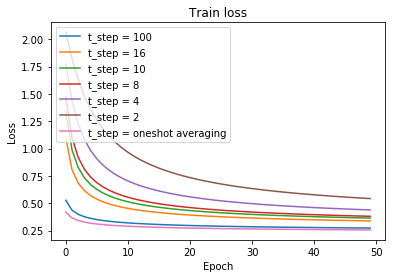

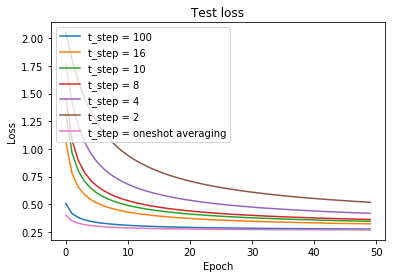

In [211]:
losses_time = [local_8_100_01,local_8_16_01,local_8_10_01,local_8_8_01,local_8_4_01,local_8_2_01,local_oneshot_8_16_01]
desc = ['t_step = 100','t_step = 16','t_step = 10','t_step = 8','t_step = 4','t_step = 2','t_step = oneshot averaging']
combined_loss(losses_time,desc)